In [ ]:
pip install pycountry pandas regex requests plotly dash

In [2]:
import requests
import zipfile
import os
import pycountry
import pandas as pd
import regex as re
from datetime import datetime

#The "download the temperature data" function
def DownloadFile(url, writeLocation):
    if requests.get(url).status_code == 200:
        with open(writeLocation, 'wb') as file:
            file.write(requests.get(url).content)
        return file
    else:
        return f"exited with {requests.get(url).status_code} as error"

def ExtractZip(zipFile, extractPath):
    try:
        with zipfile.ZipFile(zipFile, 'r') as zip_ref:
            zip_ref.extractall(extractPath)
        return extractPath
    except Exception as e:
        return f"Error: {e}"

def DownloadExtract(url, path):
    ExtractZip(DownloadFile(url, path), path)
    

def GenerateTemperatureMapping(folderPath, save=True):
    list = []
    STAIDCountry = {}
    reg = r"[\s]*(\d+),([\w\W\s]*),([a-zA-Z]{2})"
    EUList = ["Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Denmark", "Estonia", 
              "Finland", "France", "Germany", "Ireland", "Italy", "Latvia", "Luxembourg",
              "Netherlands", "Norway", "Poland", "Romania", "Spain", "Sweden", "Switzerland", 
              "United Kingdom"]
    dataframeDict = {key: [] for key in EUList}
    i = 0

    
    #Lees het Satations.txt bestand,dit heeft de index van .txt bestanden->landen
    with open(folderPath + 'stations.txt') as f:
        lines = f.readlines()
        lines = lines[17:]
        f.close()
    
    #Genereer de dictionary die ID : land bijhoudt
    #TODO: Dictionary [land] : [lijst aan IDs] als STAIDCountry?
    for line in lines:
        m = re.match(reg, line)
        if m:
            if m.group(3) not in list:
                list.append(m.group(3))
            country = pycountry.countries.get(alpha_2=m.group(3)).name
            id = str(m.group(1)).zfill(5)
            STAIDCountry[id] = country
            
    # Voor elk .txt bestand, match de ID (gelezen door regex) met de key in de dictionary, en hernoem het bestand, zo genereert het LAND[ID].txt files 
    for file in os.listdir(folderPath):
        reg = r"TG_STAID0(\d*)"
        match = re.match(reg, file)
        if not match:
            continue
        id = match.group(1)
        newName = STAIDCountry[id] + id + '.txt'
        os.rename(os.path.join(folderPath, file), os.path.join(folderPath, newName))

    
    for txtFile in os.listdir(folderPath):
        tempList = []
        dateList = []
        start = False
        temp = []
        
        with open(folderPath + txtFile) as f:
            lines = f.readlines()
            f.close()
            
        for line in lines:
            reg = r"[\d]+,\s*\d+,(\d{8}),\s*([-\d]+),\s+(\d)"
            m = re.match(reg, line.strip())
            if m:
                if m.group(3) != "0" and m.group(3) != "1":
                    continue   
                # /10 omdat alle temperatuure in stappen van 0.1 graden celcius
                dateList.append(datetime.strptime(m.group(1), "%Y%m%d").date())
                tempList.append(int(m.group(2))/10)
            else:
                temp.append(line)
                
        df = pd.DataFrame({'Date': dateList, 'Temperature' : tempList})

        reg = r"([a-zA-Z\ ]+)(\d+)"
        m = re.match(reg, txtFile)
        if not m:
            print(reg)
            print(txtFile)
            continue
        country = m.group(1)
        if country in dataframeDict.keys():
            dataframeDict[country].append(df)
        i += 1
        print(i)
        if i>9:
            break
        
    if save:
        for country, dfList in dataframeDict.items():
            if dfList != []:
                pd.concat(dfList).to_csv("data/temperature/"+str(country)+".csv", index = False)
            #  pd.concat(dfList).to_csv("data/temperature/"+str(country), index = False)
            else:
                print(f"er zijn geen dataframes gevonden voor {country}")
    
    return dataframeDict


# temperatuur is in 0.1C, dus alles x 0.1 voordat het de database in geflikkerd wordt


print(GenerateTemperatureMapping('data/temp/'))

1
2
3
4
5
6
7
8
9
10
er zijn geen dataframes gevonden voor Austria
er zijn geen dataframes gevonden voor Belgium
er zijn geen dataframes gevonden voor Bulgaria
er zijn geen dataframes gevonden voor Croatia
er zijn geen dataframes gevonden voor Cyprus
er zijn geen dataframes gevonden voor Denmark
er zijn geen dataframes gevonden voor Estonia
er zijn geen dataframes gevonden voor Finland
er zijn geen dataframes gevonden voor Ireland
er zijn geen dataframes gevonden voor Italy
er zijn geen dataframes gevonden voor Latvia
er zijn geen dataframes gevonden voor Luxembourg
er zijn geen dataframes gevonden voor Netherlands
er zijn geen dataframes gevonden voor Poland
er zijn geen dataframes gevonden voor Romania
er zijn geen dataframes gevonden voor Spain
er zijn geen dataframes gevonden voor United Kingdom
{'Austria': [], 'Belgium': [], 'Bulgaria': [], 'Croatia': [], 'Cyprus': [], 'Denmark': [], 'Estonia': [], 'Finland': [], 'France': [             Date  Temperature
0      1923-01-01         

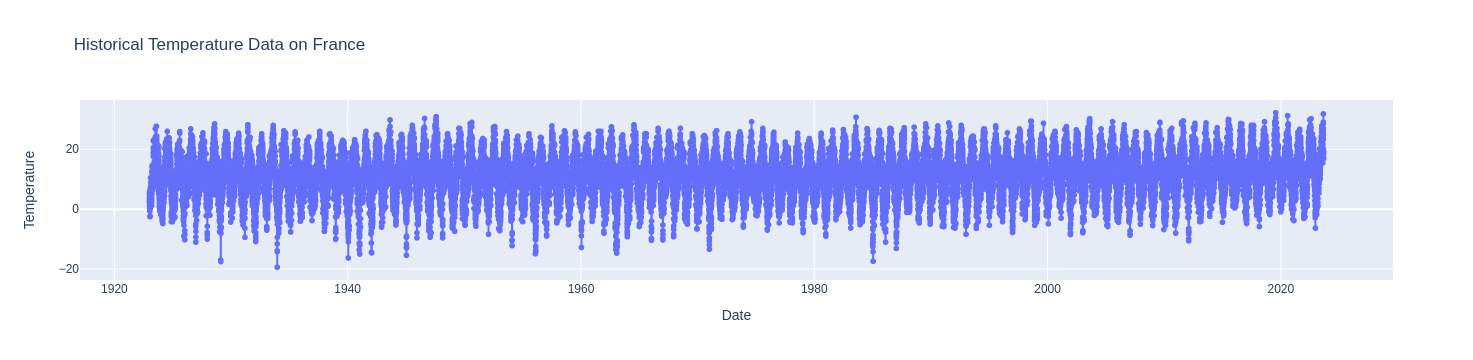

None


In [16]:
import plotly.express as px


def GenerateGraph(dataframe):
    dataframe = dataframe.sort_values(by="Date")
    fig = px.line(dataframe, x="Date", y="Temperature", title='Historical Temperature Data on France', markers=True)
    fig.show()






df = pd.read_csv("data/temperature/France.csv")
print(GenerateGraph(df))